In [14]:
import os

DataSample = dict[str, str]

def collect_data(images_dir : str, labels_dir : str) -> list[DataSample]:
    images = sorted(os.listdir(images_dir))
    labels = sorted(os.listdir(labels_dir))
    
    data = []
    for image, label in zip(images, labels):
        data.append({"image": os.path.join(images_dir, image), "label": os.path.join(labels_dir, label)})
    
    return data

def collect_dataset(train_dir : str, val_dir : str, test_dir : str) -> dict[str, list[DataSample]]:
    dataset = {"train": [], "val": [], "test": []}
    
    dataset["train"] = collect_data(os.path.join(train_dir, "images"),
                                 os.path.join(train_dir, "labels"))
    dataset["val"] = collect_data(os.path.join(val_dir, "images"),
                                 os.path.join(val_dir, "labels"))
    dataset["test"] = collect_data(os.path.join(test_dir, "images"),
                                 os.path.join(test_dir, "labels"))
    return dataset

ROOT_DIR = "./"
DATASET_PATH = "./data/datasets/astrocyte-1.1"
# DATASET_PATH = "./data"
os.chdir(ROOT_DIR)

dataset = collect_dataset(os.path.join(DATASET_PATH, "train"),
                os.path.join(DATASET_PATH, "val"),
                os.path.join(DATASET_PATH, "test"))

In [4]:
import torch
from monai.networks.nets import AttentionUnet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = AttentionUnet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    channels=(64, 128, 256, 512, 1024),
    strides=(2, 2, 2, 2),
).to(device)

checkpoint = os.path.join("checkpoints", "best.pth")
model.load_state_dict(torch.load(checkpoint, weights_only=True))

<All keys matched successfully>

In [15]:
from monai.data.dataset import Dataset
from monai.data.dataloader import DataLoader
from monai.data import NumpyReader

from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Spacingd, 
    RandFlipd, RandAffined, RandGaussianNoised, RandGaussianSmoothd, 
    NormalizeIntensityd, RandAdjustContrastd, Rand3DElasticd
)

test_transform = Compose([
    LoadImaged(keys=["image", "label"], reader=NumpyReader),
    EnsureTyped(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["label"]),
    EnsureChannelFirstd(keys=["image"], channel_dim=-1),
    
    # Intensity
    NormalizeIntensityd(keys=["image"], channel_wise=True),  # (data - mean) / std
])

test_dataset = Dataset(dataset["test"], test_transform)
test_dataloader = DataLoader(test_dataset)

In [16]:
class Dice():
    def __init__ (self, smooth=1e-6):
        self.smooth = smooth
        self.by_classes = torch.tensor([])
        
    def __call__(self, outputs : torch.Tensor, targets : torch.Tensor):
        self.intersection = (outputs & targets).sum((2, 3))
        self.union = (outputs | targets).sum((2, 3))
        self.by_classes = (2 * self.intersection) / (self.union + self.intersection + self.smooth)
        return self.by_classes.mean(dim=0)
    
    def mean(self):
        return self.by_classes.mean(dim=1).mean(dim=0)

In [148]:
import matplotlib.pyplot as plt
import numpy as np

from torchvision.utils import make_grid
def make_grid_image(images : list[torch.Tensor]):
    for i in range(len(images)):
        images[i] = torch.Tensor(images[i])[0].cpu()
        if images[i].size(0) == 1:
            images[i] = images[i].repeat(3, 1, 1)
    return make_grid(images)

In [146]:
from tqdm import tqdm
from PIL import Image

def validate(
    model : torch.nn.Module,
    batch : dict[str, torch.Tensor],
    device : torch.device,
):
    model.eval()
    step_dice = 0
    dice = Dice()
    
    with torch.no_grad():
        batch : dict[str, torch.Tensor]
        inputs, targets = batch["image"].to(device), batch["label"].to(device)

        outputs = model(inputs); outputs : torch.Tensor
        
        mask = (torch.sigmoid(outputs) > 0.2).int()
        targets = targets.int()
        
        dice(mask, targets); step_dice = dice.mean()
        grid_image = make_grid_image([inputs, targets, mask])
        
        grid_image = Image.fromarray((grid_image.permute(1, 2, 0).numpy()[:1] + (grid_image.permute(1, 2, 0).numpy()[1:] * 255)).astype("uint8"))
        
    return step_dice, grid_image

27.39703369140625

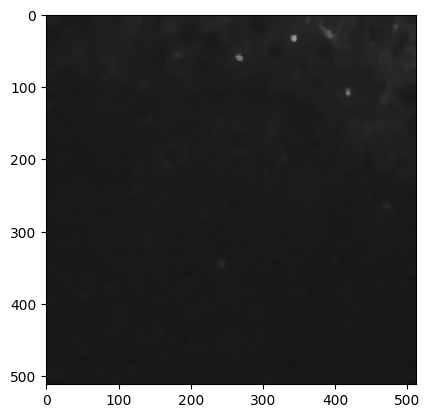

In [116]:
import matplotlib.pyplot as plt
import numpy as np

original = np.load(dataset["test"][0]["image"])
plt.imshow(original)
original.mean()

In [150]:
import tabulate
import pandas as pd
from tabulate import tabulate

results = []

mean_dice = 0

import numpy as np

for i, (meta, batch) in enumerate(zip(dataset["test"], test_dataloader)):
    idx = os.path.basename(meta["image"])
    dice, img_grid = validate(model, batch, device)
    mean_dice += dice
    
    results.append({"idx": idx, "mean": dice})
    img_grid.save(os.path.join("output", "{}_img_grid.png".format(idx)))
    
mean_dice /= len(test_dataloader)
results.append({"idx": "overall", "mean": mean_dice})

results_df = pd.DataFrame(results)
results_df = results_df.round(4)

print(tabulate(results_df, headers="keys", tablefmt="fancy_grid", numalign="center", floatfmt=".4f"))

╒════╤══════════════════════════════════════════════════════╤════════╕
│    │ idx                                                  │  mean  │
╞════╪══════════════════════════════════════════════════════╪════════╡
│ 0  │ 0101_png.rf.eaff03e973a515def176e99b3bbbb1b2.jpg.npy │ 0.6333 │
├────┼──────────────────────────────────────────────────────┼────────┤
│ 1  │ 0201_png.rf.80523f2f45061f74159edc048bbd21f0.jpg.npy │ 0.6469 │
├────┼──────────────────────────────────────────────────────┼────────┤
│ 2  │ 0302_png.rf.c4281ccc8c53b16d7d70487e825ecf43.jpg.npy │ 0.7568 │
├────┼──────────────────────────────────────────────────────┼────────┤
│ 3  │ overall                                              │ 0.6790 │
╘════╧══════════════════════════════════════════════════════╧════════╛
